# 期末项目
由于该代码文件由多个代码文件整合而成，考虑时间成本问题，并未重新运行所有单元格，因此部分单元格没有输出。

## 1 数据处理
- 通过对每张图片左旋转、右旋转15°进行数据增强，最终得到网络图片1189张，原创图片872张，共2061张
- 使用labelme对数据进行标注，包括脸部边框以及脸部5个关键点位置：左眼、右眼、鼻子、左嘴角、右嘴角，标注之后会生成相应的json文件
- Yolo对数据格式有要求，因此需要根据要求将labelme的json标注文件转换成Yolo的txt文件
- DeepPose模型通过微调ResNet50实现，DataLoader由自己创建，这里直接读取txt文件创建

### 1.1 数据增强

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import csv
from tqdm import tqdm
import time

In [ ]:
# 图片所在的文件夹路径
image_folder_path = r"D:\pku\deeplearning\test\sample_wyx_smq_lhw"
# 获取文件夹下所有图片文件名
image_files = [f for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]

# 旋转角度（单位：度），左转为负，右转为正
angle_left = -15
angle_right = 15

# 遍历每张图片
for image_file in image_files:
    # 读取图片
    image_path = os.path.join(image_folder_path, image_file)
    img = cv2.imread(image_path)

    # 获取图片的高度和宽度
    height, width = img.shape[:2]
    # 计算旋转中心坐标
    center = (width // 2, height // 2)

    # 构建旋转矩阵，设置缩放因子为1，填充颜色为白色（BGR格式：(255, 255, 255)）
    rotation_matrix_left = cv2.getRotationMatrix2D(center, angle_left, 1)
    rotation_matrix_right = cv2.getRotationMatrix2D(center, angle_right, 1)
    rotated_image_left = cv2.warpAffine(img, rotation_matrix_left, (width, height), borderMode=cv2.BORDER_CONSTANT,
                                         borderValue=(255, 255, 255))
    rotated_image_right = cv2.warpAffine(img, rotation_matrix_right, (width, height), borderMode=cv2.BORDER_CONSTANT,
                                          borderValue=(255, 255, 255))

    # 获取原文件名（不含扩展名）和扩展名
    file_name_without_extension, file_extension = os.path.splitext(image_file)
    # 构建新的文件名
    new_file_name_left = file_name_without_extension + "_left" + file_extension
    new_file_name_right = file_name_without_extension + "_right" + file_extension

    # 保存旋转后的图片到原文件夹
    new_image_path_left = os.path.join(image_folder_path, new_file_name_left)
    new_image_path_right = os.path.join(image_folder_path, new_file_name_right)
    cv2.imwrite(new_image_path_left, rotated_image_left)
    cv2.imwrite(new_image_path_right, rotated_image_right)

### 1.2 数据标注-labelme

In [ ]:
# 安装labelme
pip install labelme

安装之后直接在终端运行labelme即可打开程序进行标注，标注界面如下所示，标注完成之后会生成相应json文件

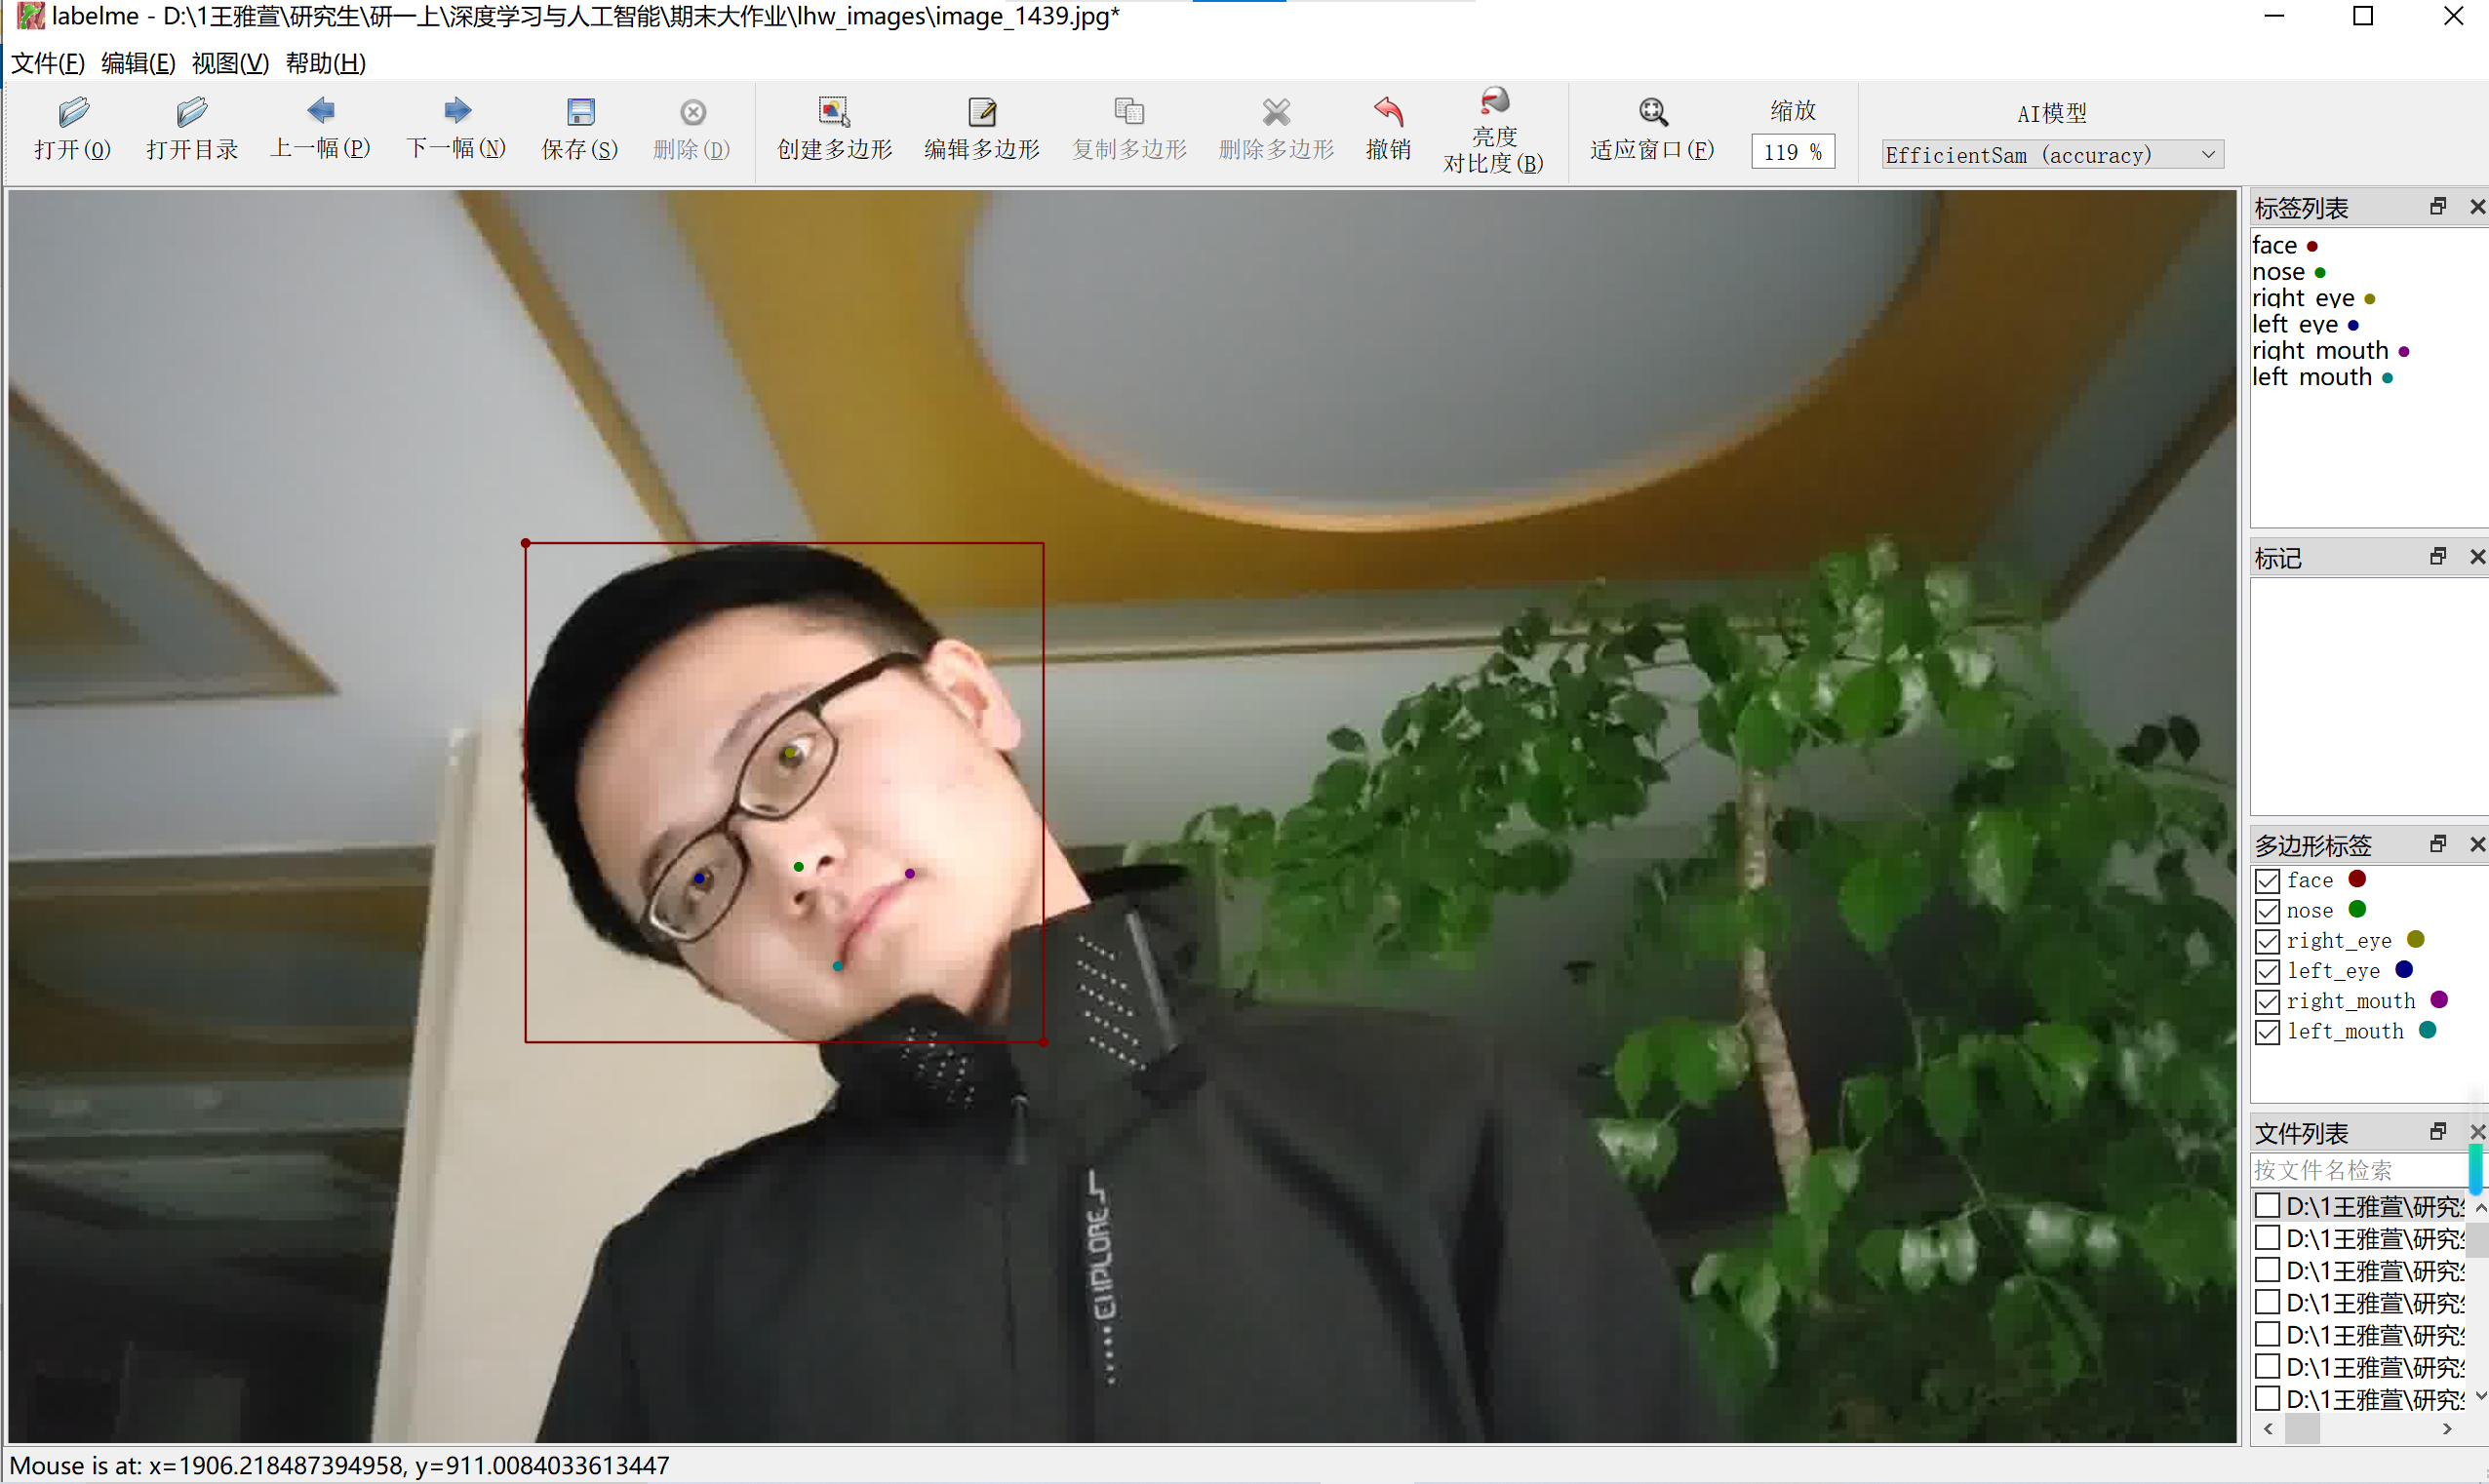

### 1.3 将labelme标注数据转换成yolo格式
将标注好的数据按照8:2划分为训练集和测试集，并转换成yolo格式

In [ ]:
import os
import json
import shutil
import numpy as np
from tqdm import tqdm

In [ ]:
# 框的类别
bbox_class = {
    'face':0  
}

# 关键点的类别
keypoint_class = ['nose', 'right_eye', 'left_eye', 'right_mouth', 'left_mouth']

In [ ]:
def process_single_json(labelme_path, save_folder='../../labels/train'):
    
    with open(labelme_path, 'r', encoding='utf-8') as f:
        labelme = json.load(f)

    img_width = labelme['imageWidth']   # 图像宽度
    img_height = labelme['imageHeight'] # 图像高度

    # 生成 YOLO 格式的 txt 文件
    suffix = labelme_path.split('.')[-2]
    yolo_txt_path = suffix + '.txt'

    with open(yolo_txt_path, 'w', encoding='utf-8') as f:

        for each_ann in labelme['shapes']: # 遍历每个标注

            if each_ann['shape_type'] == 'rectangle': # 每个框，在 txt 里写一行

                yolo_str = ''

                ## 框的信息
                # 框的类别 ID
                bbox_class_id = bbox_class[each_ann['label']]
                yolo_str += '{} '.format(bbox_class_id)
                # 左上角和右下角的 XY 像素坐标
                bbox_top_left_x = int(min(each_ann['points'][0][0], each_ann['points'][1][0]))
                bbox_bottom_right_x = int(max(each_ann['points'][0][0], each_ann['points'][1][0]))
                bbox_top_left_y = int(min(each_ann['points'][0][1], each_ann['points'][1][1]))
                bbox_bottom_right_y = int(max(each_ann['points'][0][1], each_ann['points'][1][1]))
                # 框中心点的 XY 像素坐标
                bbox_center_x = int((bbox_top_left_x + bbox_bottom_right_x) / 2)
                bbox_center_y = int((bbox_top_left_y + bbox_bottom_right_y) / 2)
                # 框宽度
                bbox_width = bbox_bottom_right_x - bbox_top_left_x
                # 框高度
                bbox_height = bbox_bottom_right_y - bbox_top_left_y
                # 框中心点归一化坐标
                bbox_center_x_norm = bbox_center_x / img_width
                bbox_center_y_norm = bbox_center_y / img_height
                # 框归一化宽度
                bbox_width_norm = bbox_width / img_width
                # 框归一化高度
                bbox_height_norm = bbox_height / img_height

                yolo_str += '{} {} {} {} '.format(bbox_center_x_norm, bbox_center_y_norm, bbox_width_norm, bbox_height_norm)

                ## 找到该框中所有关键点，存在字典 bbox_keypoints_dict 中
                bbox_keypoints_dict = {}
                for each_ann in labelme['shapes']: # 遍历所有标注
                    if each_ann['shape_type'] == 'point': # 筛选出关键点标注
                        # 关键点XY坐标、类别
                        x = int(each_ann['points'][0][0])
                        y = int(each_ann['points'][0][1])
                        label = each_ann['label']
                        if (x>bbox_top_left_x) & (x<bbox_bottom_right_x) & (y<bbox_bottom_right_y) & (y>bbox_top_left_y): # 筛选出在该个体框中的关键点
                            bbox_keypoints_dict[label] = [x, y]

                ## 把关键点按顺序排好
                for each_class in keypoint_class: # 遍历每一类关键点
                    if each_class in bbox_keypoints_dict:
                        keypoint_x_norm = bbox_keypoints_dict[each_class][0] / img_width
                        keypoint_y_norm = bbox_keypoints_dict[each_class][1] / img_height
                        yolo_str += '{} {} {} '.format(keypoint_x_norm, keypoint_y_norm, 2) # 2-可见不遮挡 1-遮挡 0-没有点
                    else: # 不存在的点，一律为0
                        yolo_str += '0 0 0 '
                # 写入 txt 文件中
                f.write(yolo_str + '\n')
                
    shutil.move(yolo_txt_path, save_folder)
    print('{} --> {} 转换完成'.format(labelme_path, yolo_txt_path))    

In [ ]:
## 转换训练集标注文件
# 切换到训练集所在的目录
os.chdir('train')
# 定义保存转换后标注文件的文件夹路径
save_folder = '../labels/train'
for labelme_path in os.listdir():
    try:
        # 尝试处理单个JSON标注文件，并保存到指定的文件夹
        process_single_json(labelme_path, save_folder=save_folder)
    except:
        print('******有误******', labelme_path)
print('YOLO格式的txt标注文件已保存至 ', save_folder)

## 转换测试集标注文件
# 切换到测试集所在的目录
os.chdir('val')
# 定义保存转换后标注文件的文件夹路径
save_folder = '../labels/val'
for labelme_path in os.listdir():
    try:
        # 尝试处理单个JSON标注文件，并保存到指定的文件夹
        process_single_json(labelme_path, save_folder=save_folder)
    except:
        print('******有误******', labelme_path)
print('YOLO格式的txt标注文件已保存至 ', save_folder)

## 2 模型训练

### 2.1 DeepPose
DeepPose模型使用预训练的ResNet50进行迁移学习，将其线性层输出维数改为关键点数×2，对应每个关键点的x和y坐标，在标注好的数据中进行微调。代码主要分为三个部分：  

(1) 数据读取
- 定义数据集类并构建数据读取器。
- 展示第一批次的训练数据。

(2) 损失函数和评价函数的定义
- 本次作业尝试了L1 loss、Smooth-L1 loss和Wing loss三种损失函数，最终使用Wing loss，三种损失函数的公式如下：
$$ L1(x) = |x| $$
$$ \text{smooth}_{L1}(x) = \begin{cases} 
\frac{1}{2}x^2, & \text{if } |x| < 1 \\
|x| - \frac{1}{2}, & \text{otherwise}
\end{cases} $$
$$ \text{wing}(x) = \begin{cases} 
w\ln(1 + \frac{|x|}{\epsilon}), & \text{if } |x| < w \\
|x| - C, & \text{otherwise}
\end{cases} $$
- Wing Loss在2017年被提出，用于提高卷积神经网络在面部关键点定位任务中的性能。这种损失函数的设计灵感来源于对人类认知过程的模拟，即人类对小误差的容忍度较高，但对大误差则更为敏感。Wing Loss通过一个非线性的"翼"形状来模拟这种特性，即在较小误差时损失较平缓，而在较大误差时损失陡峭。这种特性使得Wing Loss在处理小误差时能够提供更平缓的梯度，有助于模型的稳定训练，同时在处理大误差时提供较大的梯度，从而加速模型的收敛。在论文中$w=10, \epsilon=2$，本次作业使用该参数设置。
- NME是一个常用的面部关键点检测评价指标，它使用两眼间距对关键点的预测误差进行归一化，便于不同大小的面部图像的预测误差之间的比较。

(3) 模型训练
- 使用预训练的ResNet50进行迁移学习，将其线性层输出维数改为关键点数×2，对应每个关键点的x和y坐标。
- 在标注好的数据中训练100轮，并保存在测试集上损失函数最小、评价指标最好的模型及最后一轮的模型。
- 经过100轮训练以后，模型在训练集和测试集上的损失函数均逐步减小，评价指标也逐渐变好，但最终均趋近于一个大于0的数，无法收敛，说明该模型在完成面部关键点识别任务时表现不佳。

In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from itertools import islice
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
from torchsummary import summary
import time
import torch.optim as optim
import torch.nn.functional as F
import math

In [2]:
if torch.cuda.is_available(): # 如果有可用的cuda设备
    device = 'cuda'  # 则设置为cuda
else: # 如果没有
    device = 'cpu'  # 则为cpu

In [3]:
size1 = 256  # 形状的第一个维度（图片高的像素）
size2 = 256  # 形状的第二个维度（图片宽的像素）
img_hw = [size1, size2]
num_keypoints = 5  # 关键点数量

In [4]:
transform = transforms.Compose([  
    transforms.Resize((size1, size2)),  # 变形为网络所需的输入形状（size1 * size2）
    transforms.ToTensor()  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

#### 2.1.1 数据读取

In [5]:
def default_loader(path):  # 定义加载方式
    return Image.open(path)  # 使用Image.open方式加载图片

class Dataset():  # 定义数据集类
    def __init__(self, loader=default_loader, transform=None, directory='./datasets/dataset/images/train'):  # 初始化类
        imgs = []  # 初始化一个空列表用来存储图片路径和关键点数据
        # 列出指定目录下的所有文件名
        ims = os.listdir(directory)
        for im in ims:
            # 构建标签文件的路径
            file_path = './datasets/dataset/labels/' + directory.split('/')[-1] + '/' + im[: -4] + '.txt'
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    # 将行内容分割成元素列表
                    words = line.split()
            # 提取关键点坐标
            keypoint_ = words[5: 7] + words[8: 10] + words[11: 13] + words[14: 16] + words[17: 19]
            # 将字符串坐标转换为浮点数
            keypoint_ = [float(x) for x in keypoint_]
            # 转换为numpy数组并重塑为(-1, 2)的形状
            keypoint = np.array(keypoint_, dtype=np.float32).reshape((-1, 2))
            # 构建完整的图片文件路径
            im = directory + '/' + im
            # 将图片路径和关键点添加到imgs列表中
            imgs.append((im, keypoint))
        self.imgs = imgs  # 将列表赋值给类属性 
        self.loader = loader  # 设置图片加载器
        self.transform = transform  # 设置图片预处理变换方式
        
    def __len__(self):  # 定义Python内置的len()函数
        return len(self.imgs)  # 返回数据集长度 
    
    def __getitem__(self, index):  # 定义类的索引操作
        images, labels = self.imgs[index]  # 根据索引获取图片路径和关键点位置
        img = self.loader(images)  # 使用加载器加载图片
        img = self.transform(img)  # 对图片进行预处理
        return img, labels  # 返回处理好的图片和关键点位置

In [6]:
train_set = Dataset(transform=transform, directory='./datasets/dataset/images/train')  # 训练数据集构造
val_set = Dataset(transform=transform, directory='./datasets/dataset/images/val')  # 测试数据集构造

In [7]:
# 构建数据读取器
batch_size = 64  
# 构建训练集生成器，训练集进行打乱
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4) 
# 构建测试集生成器，测试集不进行打乱 
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)  

torch.Size([64, 3, 256, 256])
torch.Size([64, 5, 2])


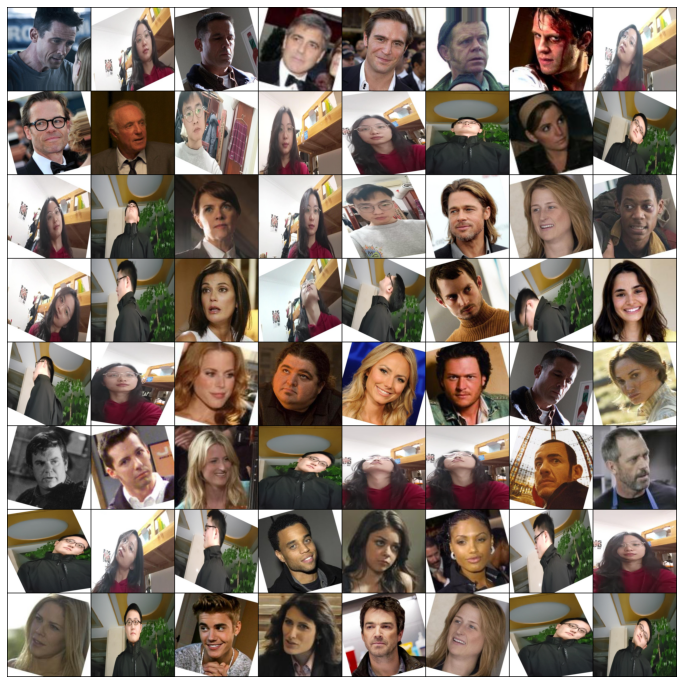

In [8]:
# 数据展示（第一批次）
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应关键点位置
print(images.shape)  # 打印图片的张量形状
print(labels.shape)  # 打印关键点位置的张量形状
plt.figure(figsize=(12, 20))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()  # 展示图片

#### 2.1.2 损失函数和评价指标的定义

In [9]:
# 三种损失函数，最终使用WingLoss函数
# L1损失函数类，继承自nn.Module
class L1Loss(nn.Module):
    def __init__(self) -> None:
        # 调用父类的初始化方法
        super().__init__()

    # 前向传播方法，计算L1损失
    def forward(self, 
                pred: torch.Tensor, 
                label: torch.Tensor,
                wh_tensor: torch.Tensor,
                mask: torch = None) -> torch.Tensor:
        """
        Args:
            pred [N, K, 2]
            label [N, K, 2]
            mask [N, K]
        """
        # 计算L1损失，不进行平均或求和
        losses = F.l1_loss(pred, label, reduction="none")
        if mask is not None:
            # 如果提供了掩码，将损失与掩码相乘，忽略无效的关键点
            losses = losses * mask.unsqueeze(2)

        # 返回所有样本的平均损失
        return torch.mean(torch.sum(losses, dim=(1, 2)), dim=0)

# 平滑L1损失函数类，继承自nn.Module
class SmoothL1Loss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    # 前向传播方法，计算平滑L1损失
    def forward(self, 
                pred: torch.Tensor, 
                label: torch.Tensor, 
                wh_tensor: torch.Tensor,
                mask: torch = None) -> torch.Tensor:
        """
        Args:
            pred [N, K, 2]
            label [N, K, 2]
            mask [N, K]
        """
        # 计算平滑L1损失，不进行平均或求和
        losses = F.smooth_l1_loss(pred, label, reduction="none")
        if mask is not None:
            # 如果提供了掩码，将损失与掩码相乘，忽略无效的关键点
            losses = losses * mask.unsqueeze(2)

        # 返回所有样本的平均损失
        return torch.mean(torch.sum(losses, dim=(1, 2)), dim=0)

# Wing损失函数类，继承自nn.Module
class WingLoss(nn.Module):
    """refer https://github.com/TropComplique/wing-loss/blob/master/loss.py
    """
    def __init__(self, w: float = 10.0, epsilon: float = 2.0) -> None:
        super().__init__()
        self.w = w  # Wing Loss的参数w
        self.epsilon = epsilon  # Wing Loss的参数epsilon
        self.C = w * (1.0 - math.log(1.0 + w / epsilon))  # 根据w和epsilon计算常数C

    # 前向传播方法，计算Wing Loss
    def forward(self,
                pred: torch.Tensor,
                label: torch.Tensor,
                wh_tensor: torch.Tensor,
                mask: torch = None) -> torch.Tensor:
        """
        Args:
            pred [N, K, 2]
            wh_tensor [1, 1, 2]
            label [N, K, 2]
            mask [N, K]
        """
        # 计算预测和真实关键点之间的相对绝对差值
        delta = (pred - label).abs() * wh_tensor  
        # 根据delta与w的比较结果选择损失计算方式
        losses = torch.where(condition=self.w > delta,
                             input=self.w * torch.log(1.0 + delta / self.epsilon),
                             other=delta - self.C)
        if mask is not None:
            # 如果提供了掩码，将损失与掩码相乘，忽略无效的关键点
            losses = losses * mask.unsqueeze(2)

        # 返回所有样本的平均损失
        return torch.mean(torch.sum(losses, dim=(1, 2)), dim=0)

In [10]:
# 评价指标
class NMEMetric:
    def __init__(self, device: torch.device) -> None:
        # 两眼对应的keypoint索引
        self.keypoint_idxs = [1, 2]
        # 初始化累积变量，用于存储所有样本的NME值
        self.nme_accumulator: float = 0.
        # 初始化计数器，用于存储有效样本的数量
        self.counter: float = 0.
        # 存储设备信息，例如CPU或GPU
        self.device = device

    # 更新方法，用于在每个批次后更新NME值
    def update(self, pred: torch.Tensor, gt: torch.Tensor, mask: torch.Tensor = None):
        """
        Args:
            pred (shape [N, K, 2]): pred keypoints
            gt (shape [N, K, 2]): gt keypoints
            mask (shape [N, K]): valid keypoints mask
        """
        # 计算两眼之间的距离（ion），用于后续的归一化
        ion = torch.linalg.norm(gt[:, self.keypoint_idxs[0]] - gt[:, self.keypoint_idxs[1]], dim=1)

        # 创建一个掩码，用于筛选眼间距离大于0的样本
        valid_ion_mask = ion > 0
        # 如果没有提供掩码，则使用眼间距离大于0的掩码
        if mask is None:
            mask = valid_ion_mask
        # 如果提供了掩码，则与眼间距离大于0的掩码进行逻辑与操作
        else:
            mask = torch.logical_and(mask, valid_ion_mask.unsqueeze_(dim=1)).sum(dim=1) > 0
        # 计算有效样本的数量
        num_valid = mask.sum().item()

        # 计算预测关键点和真实关键点之间的L2距离
        l2_dis = torch.linalg.norm(pred - gt, dim=2)[mask].mean(dim=1)  

        # 避免除以零的错误，只选择有效样本的眼间距离
        ion = ion[mask]  

        # 更新累积的NME值和计数器
        self.nme_accumulator += l2_dis.div(ion).sum().item()
        self.counter += num_valid

    # 评估方法，用于计算最终的NME值
    def evaluate(self):
        # 返回累积的NME值除以有效样本的数量，即平均NME
        return self.nme_accumulator / self.counter

#### 2.1.3 模型训练

In [11]:
# 模型验证
def validate(model, testloader):

    model.eval()  # 给网络做标记，标志着模型在测试集上训练
    loss_func = WingLoss()  # 初始化WingLoss损失函数
    val_loss = 0  # 测试集损失初始化为0
    metric = NMEMetric(device=device)  # 初始化NMEMetric评价指标
    # 将图像的宽高转换为tensor，并调整为[1, 1, 2]的形状，用于WingLoss中的wh_tensor
    wh_tensor = torch.as_tensor(img_hw[::-1], dtype=torch.float32, device=device).reshape([1, 1, 2])
    
    for inputs, labels in testloader:  # 遍历测试集中的样本
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        
        outputs = model(inputs)  # 计算模型输出
        
        # 计算损失，注意outputs需要reshape以匹配WingLoss的输入要求
        loss = loss_func(outputs.reshape((-1, num_keypoints, 2)), labels, wh_tensor)
        val_loss += loss.item()  # 累加损失
        
        pred = outputs.reshape((-1, num_keypoints, 2))  # [N, K, 2]
        pred = pred * wh_tensor  # 将模型输出的相对坐标转换为绝对坐标
        metric.update(pred, labels)  # 更新NME评价指标
    
    val_loss /= len(testloader)  # 计算平均测试集损失
    val_nme = metric.evaluate()  # 计算NME值
    return val_loss, val_nme   # 返回平均测试集损失和NME值

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_nme, val_loss, val_nme):
    # 打印当前的训练周期、训练时间、训练损失、训练NME、验证集损失和验证集NME
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, nme: {train_nme:.4f}, val_loss: {val_loss:.4f}, val_nme: {val_nme:.4f}")

In [12]:
import time
# 模型训练
def train(model, trainloader, testloader, epochs=1, lr=1e-3):
    
    # 尝试从文件中读取历史最小的验证损失和NME，如果文件不存在则初始化为一个较大的数
    try:
        with open('./model_50/min_val_loss.txt', 'r') as file:
            min_val_loss = file.read()  
        min_val_loss = float(min_val_loss)
        with open('./model_50/min_val_nme.txt', 'r') as file:
             min_val_nme = file.read()  
        min_val_nme = float(min_val_nme)
    except:
        min_val_loss = 10000
        min_val_nme = 10000
    
    # 初始化WingLoss损失函数
    loss_func = WingLoss()
    # 创建一个tensor，用于在WingLoss中将相对坐标转换为绝对坐标
    wh_tensor = torch.as_tensor(img_hw[::-1], dtype=torch.float32, device=device).reshape([1, 1, 2])
    # 初始化训练和验证的损失和NME列表
    train_losses = []; train_nmes = []
    val_losses = []; val_nmes = []
    
    for epoch in range(epochs):  # 遍历训练轮次
        model.train()  # 给网络做标记，标志着模型在训练集上训练
        train_loss = 0  # 训练损失初始化为0
        metric = NMEMetric(device=device)  # 初始化NME评价指标
        start = time.time()  # 记录本epoch开始时间
        
        for inputs, labels in trainloader:  # 遍历训练集中的样本
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            
            outputs = model(inputs)  # 计算模型输出
            
            # 计算损失
            loss = loss_func(outputs.reshape((-1, num_keypoints, 2)), labels, wh_tensor)
            # 如果损失不是有限值，则停止训练
            if not math.isfinite(loss.item()):
                print("Loss is {}, stopping training".format(loss.item()))
            train_loss += loss.item()  # 训练集损失累加，item方法提取出tensor中的数字
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数以及指定的学习率，更新参数
            
            pred = outputs.reshape((-1, num_keypoints, 2))  # [N, K, 2]
            pred = pred * wh_tensor  # 将输出的相对坐标转换为绝对坐标
            metric.update(pred, labels)  # 更新NME评价指标
            
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        train_loss /= len(trainloader)  # 计算平均损失
        train_nme = metric.evaluate()  # 计算训练NME
        
        val_loss, val_nme = validate(model, testloader)  # 在测试集上验证模型
        # 存储训练损失和NME，以及验证损失和NME
        train_losses.append(train_loss); train_nmes.append(train_nme)  
        val_losses.append(val_loss); val_nmes.append(val_nme)  
        
        # 如果本轮验证损失小于历史最小值，则保存模型并更新历史最小值
        if val_loss < min_val_loss:
            torch.save(model, './model_50/min_val_loss_model.pth')
            min_val_loss = val_loss
            with open('./model_50/min_val_loss.txt', 'w') as file:
                file.write(str(min_val_loss))
        
        # 如果本轮验证NME小于历史最小值，则保存模型并更新历史最小值
        if val_nme < min_val_nme:
            torch.save(model, './model_50/min_val_nme_model.pth')
            min_val_nme = val_nme
            with open('./model_50/min_val_nme.txt', 'w') as file:
                file.write(str(min_val_nme))
        
        # 打印本轮训练结果
        print_log(epoch + 1, train_time, train_loss, train_nme, val_loss, val_nme)  
    
    # 返回所有轮次的训练损失和NME，以及验证损失和NME
    return train_losses, train_nmes, val_losses, val_nmes  

In [13]:
# 定义模型
from torchvision.models import resnet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_keypoints * 2)
model = model.cuda()

In [14]:
# 给定超参数，定义优化器，进行模型训练
epochs = 100  # 训练轮次
lr = 1e-4  # 学习率
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 设置优化器
optimizer = torch.optim.AdamW(model.parameters())

In [15]:
train_losses, train_nmes, val_losses, val_nmes = train(model, train_loader, val_loader, epochs=epochs, lr=lr)  # 实施训练

Epoch [1/100], time: 20.61s, loss: 472.7146, nme: 2117.5707, val_loss: 2574.7455, val_nme: 2144.3018
Epoch [2/100], time: 8.02s, loss: 275.7963, nme: 2029.6610, val_loss: 300.8764, val_nme: 752.1668
Epoch [3/100], time: 8.11s, loss: 272.1391, nme: 2025.8759, val_loss: 218.5906, val_nme: 800.2299
Epoch [4/100], time: 7.93s, loss: 290.0784, nme: 1967.7870, val_loss: 320.0561, val_nme: 910.6381
Epoch [5/100], time: 8.00s, loss: 284.6378, nme: 2034.4404, val_loss: 215.5545, val_nme: 857.9888
Epoch [6/100], time: 8.09s, loss: 237.7889, nme: 1949.8539, val_loss: 216.6200, val_nme: 831.7705
Epoch [7/100], time: 7.96s, loss: 240.9525, nme: 1942.6974, val_loss: 215.4957, val_nme: 865.1276
Epoch [8/100], time: 7.81s, loss: 226.5099, nme: 1941.7823, val_loss: 205.5868, val_nme: 818.0275
Epoch [9/100], time: 8.02s, loss: 204.6894, nme: 1917.2571, val_loss: 219.2096, val_nme: 788.4891
Epoch [10/100], time: 8.02s, loss: 195.2271, nme: 1896.8977, val_loss: 180.4756, val_nme: 813.6612
Epoch [11/100], 

In [16]:
torch.save(model, './model_50/last_epoch_model.pth')

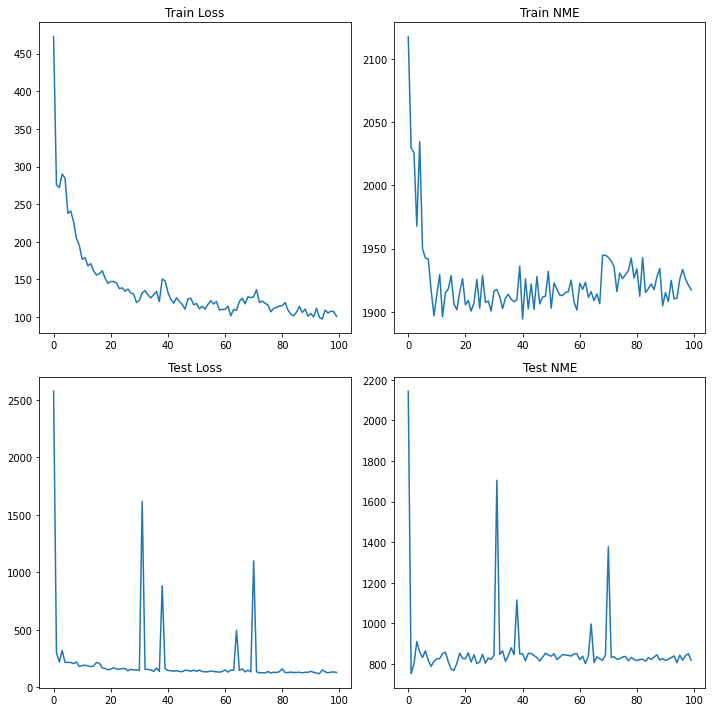

In [18]:
# 创建一个2x2的子图布局
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 在第一个子图中绘制Train Loss
axs[0, 0].plot(train_losses)
axs[0, 0].set_title('Train Loss')

# 在第二个子图中绘制Train NME
axs[0, 1].plot(train_nmes)
axs[0, 1].set_title('Train NME')

# 在第三个子图中绘制Test Loss
axs[1, 0].plot(val_losses)
axs[1, 0].set_title('Test Loss')

# 在第四个子图中绘制Test NME
axs[1, 1].plot(val_nmes)
axs[1, 1].set_title('Test NME')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

### 2.2 YoloV8
- 使用Yolov8s-pose的预训练模型，在标注好的数据中微调50轮实现。
- 经过50轮的训练，模型在训练集和测试集上的各种损失均逐渐收敛至0，说明基于Yolov8s-pose的微调模型在完成面部关键点识别任务上表现较佳。

In [ ]:
# 安装YoloV8
pip install ultralytics --upgrade -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
# 验证安装成功
import ultralytics
ultralytics.checks()

In [ ]:
# 安装其它第三方工具包
pip install numpy opencv-python pillow pandas matplotlib seaborn tqdm wandb seedir emoji -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
# 在终端运行以下代码即可对YoloV8的关键点标注模型进行微调
yolo pose train data=dataset.yaml model=yolov8s-pose.pt pretrained=True project=elsrk name=s_pretrain epochs=50 batch=64 device=0

其中，dataset.yaml为YoloV8训练所需文件，其内容为：

---
path: dataset

train: images/train  
val: images/val  
test: images/val  

kpt_shape: [5, 3]

names:  
  0: face
  
---

Yolov8s-pose模型的结构如下所示：  
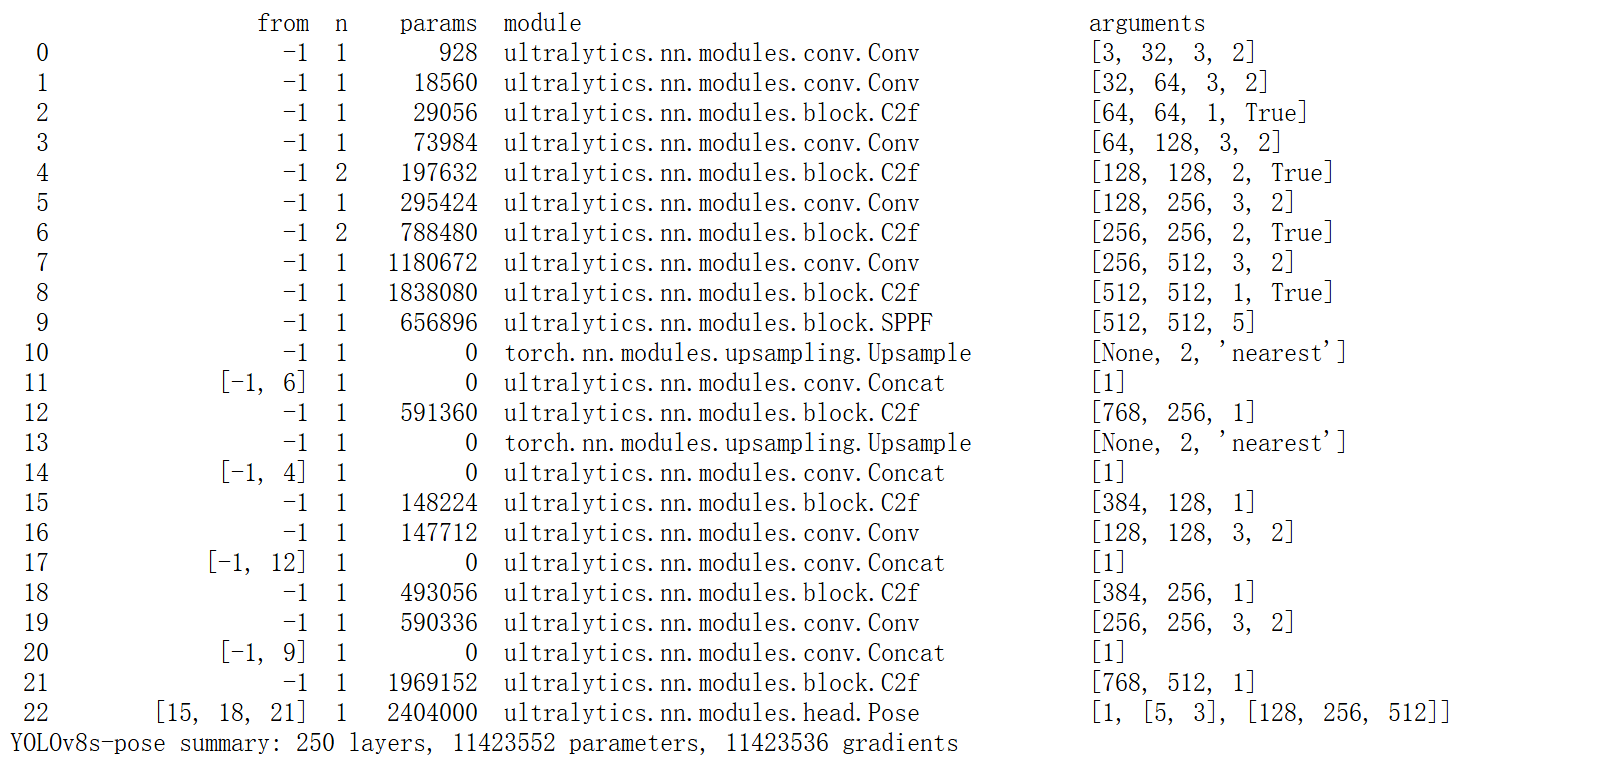

---

训练过程如下所示，由图可知，经过50轮的训练，模型在训练集和测试集上的各种损失均逐渐收敛至0：
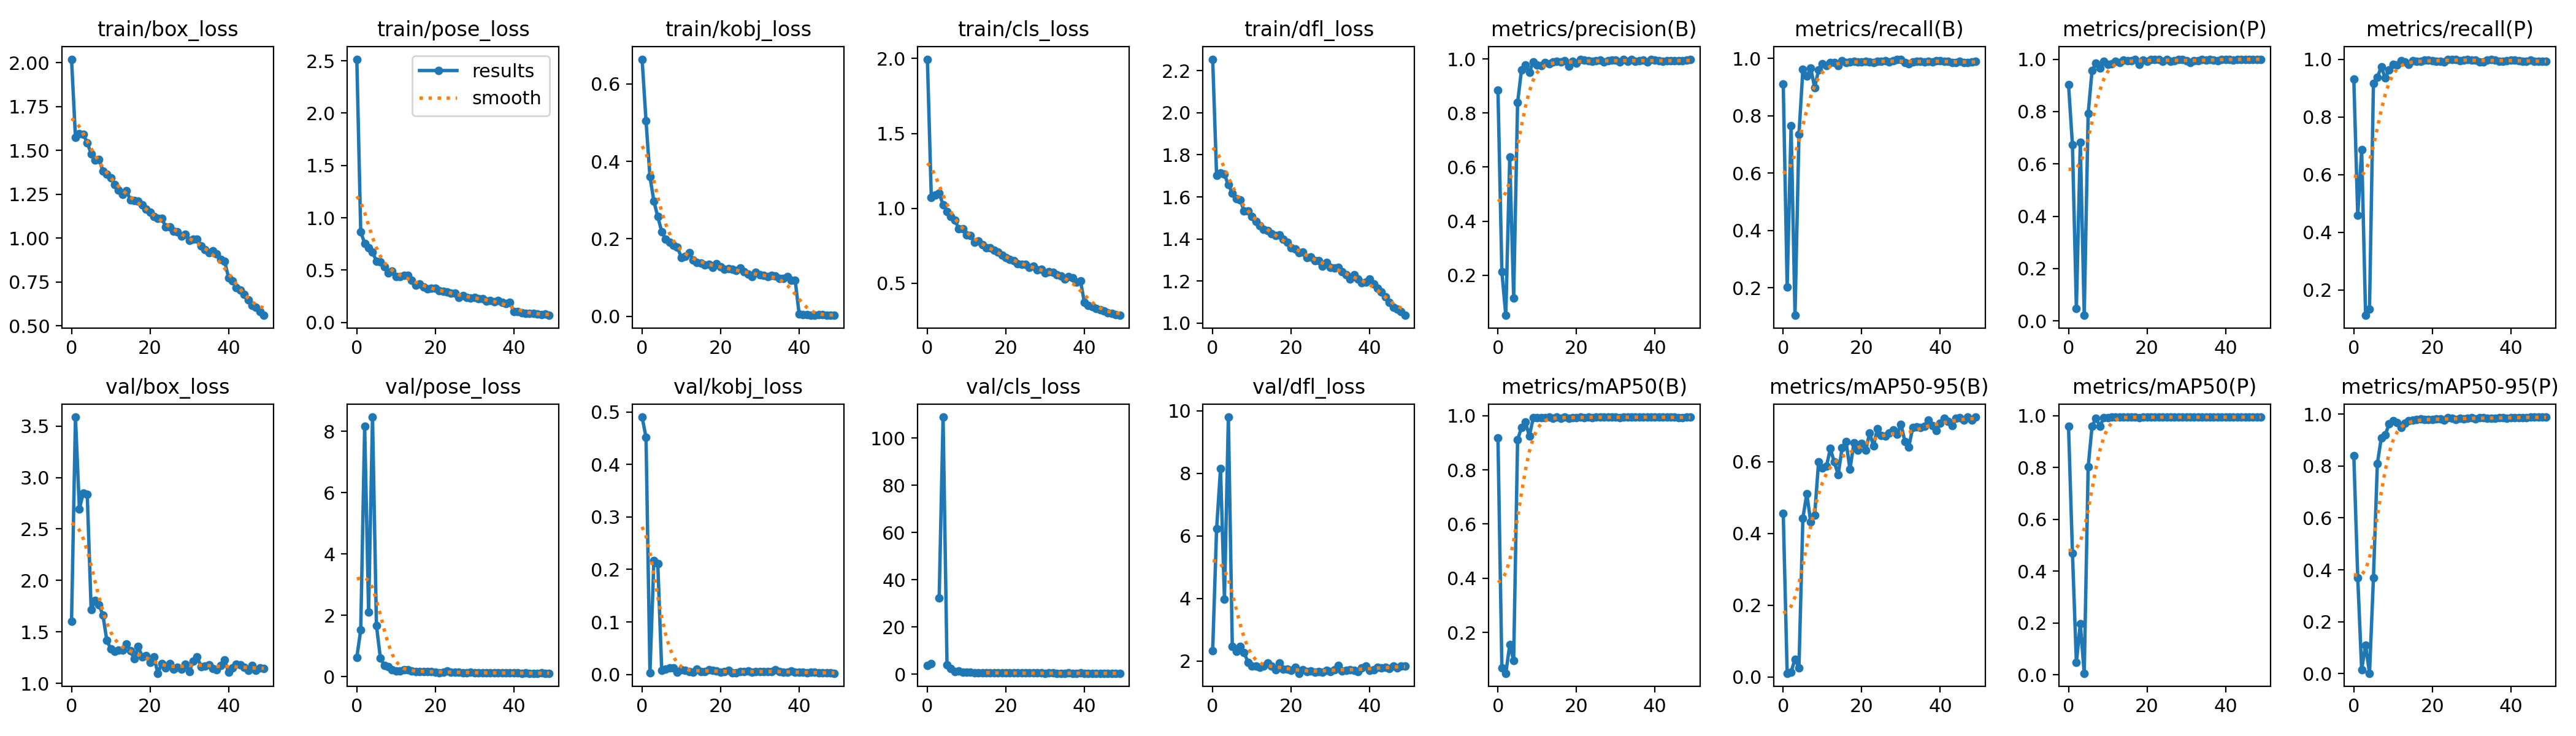

## 3 模型推断
- 对比DeepPose模型和YoloV8的微调模型的在训练集、测试集上的指标表现及在测试集图片上的具体推断结果，YoloV8的微调模型明显优于DeepPose模型。
- 此外，基于Yolov8s-pose的微调模型的参数量（11,423,552）小于DeepPose模型（23,528,522），推断速度更快。
- 因此，本小组最后选择基于Yolov8s-pose的微调模型作为项目最终的面部关键点识别模型。

### 3.1 DeepPose
这里直接载入在测试集上损失函数最小的模型进行推断。

In [41]:
# 加载训练好的模型
model = torch.load('./model_50/min_val_loss_model.pth')

预测点位
tensor([[[0.2880, 0.5820],
         [0.3365, 0.4666],
         [0.1777, 0.5472],
         [0.3639, 0.6686],
         [0.2549, 0.7193]]], device='cuda:0')
时间:  0.07556796073913574
FPS:  13.233121421021911


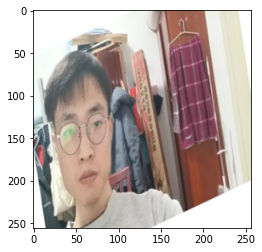

In [42]:
start = time.time()  # 记录开始时间，用于计算推理时间
file_path = "./test/test.jpg"  # 定义图片路径
my_image = Image.open(file_path)  # 加载图片
my_image = transform(my_image)  # 对图片进行预处理
plt.imshow(make_grid(my_image.unsqueeze(0), nrow=1).permute((1, 2, 0)))  # 显示图片

with torch.no_grad():  # 使用torch.no_grad()来关闭梯度计算，因为在推理时不需要反向传播
    output = model.forward(my_image.unsqueeze(0).to(device))  # 输出预测结果
    
# 将输出的预测结果重塑为[-1, num_keypoints, 2]的形状，其中num_keypoints是关键点的数量
pred = output.reshape((-1, num_keypoints, 2)) 
print('预测点位')
print(pred)
end = time.time()  # 记录本epoch结束时间
print('时间: ', end - start)
print('FPS: ', 1/(end - start))

276 316
323 253
170 297
349 363
244 391


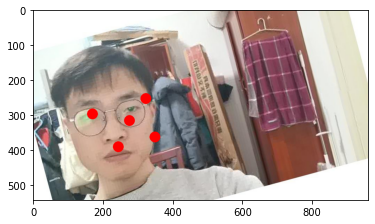

In [43]:
# 将模型预测的关键点位置还原到原始图片中
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 使用OpenCV读取图片
my_image = cv2.imread(file_path)
# 获取图片的高度和宽度
h, w = my_image.shape[: 2]
# 设置绘制关键点时的椭圆大小
point_size = 15

# 使用PIL打开图片，以便使用ImageDraw进行绘制
my_image = Image.open(file_path)
# 创建一个ImageDraw对象，用于在图片上绘制
draw = ImageDraw.Draw(my_image)

# 遍历预测的关键点坐标
for x, y in pred[0]:
    # 将归一化的关键点坐标转换为原始图片的像素坐标
    x = int(x * w)
    y = int(y * h)
    # 在图片上绘制一个红色的椭圆，表示关键点的位置
    draw.ellipse((x - point_size, y - point_size, x + point_size, y + point_size), fill='red')
    print(x, y)

# 显示图片
plt.imshow(my_image)

### 3.2 YoloV8
同样载入最好的模型进行推断。

In [44]:
from ultralytics import YOLO
import torch

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


In [45]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 6                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':4,         # 字体大小
    'font_thickness':10,   # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-80,        # Y 方向，文字偏移距离，向下为正
}

# 关键点配色
kpt_color_map = {
    0:{'name':'nose', 'color':[0,0,255], 'radius':10},
    1:{'name':'right_eye', 'color':[255,0,0], 'radius':10},
    2:{'name':'left_eye', 'color':[0,255,0], 'radius':10},
    3:{'name':'right_mouth', 'color':[255,255,0], 'radius':10},
    4:{'name':'left_mouth', 'color':[0,255,255], 'radius':10}
}

# 点类别文字
kpt_labelstr = {
    'font_size':4,             # 字体大小
    'font_thickness':10,       # 字体粗细
    'offset_x':30,             # X 方向，文字偏移距离，向右为正
    'offset_y':100,            # Y 方向，文字偏移距离，向下为正
}

In [46]:
# 加载微调好的YOLO模型
model = YOLO('checkpoint/s_best_full_50.pt')
# 将模型转移到指定的设备上
model.to(device)

In [47]:
# 定义要进行预测的图片路径
img_path = 'test/test.jpg'
# 使用模型对图片进行预测，results将包含预测结果
results = model(img_path)


image 1/1 /mnt/期末作业/test/test.jpg: 384x640 1 face, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


In [48]:
# 获取预测的边界框数量
num_bbox = len(results[0].boxes.cls)
print('预测出 {} 个框'.format(num_bbox))
# 将预测的边界框坐标转换为整数的numpy数组
bboxes_xyxy = results[0].boxes.xyxy.cpu().numpy().astype('uint32')
# 将预测的关键点坐标转换为整数的numpy数组
bboxes_keypoints = results[0].keypoints.xy.cpu().numpy().astype('uint32')

预测出 1 个框


In [49]:
img_bgr = cv2.imread(img_path)

for idx in range(num_bbox): # 遍历每个框
    
    # 获取该框坐标
    bbox_xyxy = bboxes_xyxy[idx] 
    
    # 获取框的预测类别（对于关键点检测，只有一个类别）
    bbox_label = results[0].names[0]
    
    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)
    
    # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
    img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])
    
    bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度
    
    # 画该框的关键点
    for kpt_id in kpt_color_map:
        
        # 获取该关键点的颜色、半径、XY坐标
        kpt_color = kpt_color_map[kpt_id]['color']
        kpt_radius = kpt_color_map[kpt_id]['radius']
        kpt_x = bbox_keypoints[kpt_id][0]
        kpt_y = bbox_keypoints[kpt_id][1]
        
        # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
        img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)
        
        # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        # kpt_label = str(kpt_id) # 写关键点类别 ID
        # kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称
        # img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])

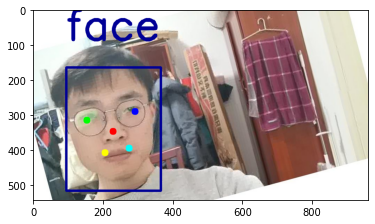

In [50]:
# 显示图像
plt.imshow(img_bgr[:,:,::-1])
plt.show()